In this notebook we train the BHRF model (Sanchez-Saez et al. 2019) using the labeled dataset. 

Input: 
- features_file: name of the file that contains the features.
- labels_file: name of the file that contains the oid and labels for the labeled light curves.
- feature_list: features to be used for the BHRF training.


Output:
- trained RF model.
- predictions over the unlabeled dataset.

In [1]:
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from sklearn import preprocessing, model_selection, metrics, ensemble
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import pickle


Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

  ### Definition of names for plots and files

In [2]:
labels_file = '../data_raw/dfcrossmatches_prioritized_v7.0.1.csv'
features_file = '../data_raw/features_20210106.parquet'

### reading the training set files 

In [3]:
features = pd.read_parquet(features_file, engine='pyarrow')
labels = pd.read_csv(labels_file,index_col='oid').reset_index()
feature_list = pd.read_pickle('../data_raw/features_RF_model.pkl')

In [4]:
labels.loc[(labels['classALeRCE'] == 'RSCVn'), 'classALeRCE'] = 'Periodic-Other'
labels.loc[(labels['classALeRCE'] == 'SNIIn'), 'classALeRCE'] = 'SNII'
labels.loc[(labels['classALeRCE'] == 'EA'), 'classALeRCE'] = 'E' 
labels.loc[(labels['classALeRCE'] == 'EB/EW'), 'classALeRCE'] = 'E'
labels.loc[(labels['classALeRCE'] == 'Ceph'), 'classALeRCE'] = 'CEP'

labels = labels[(labels['classALeRCE']!='NLAGN')]
labels = labels[(labels['classALeRCE']!='NLQSO')]
labels = labels[(labels['classALeRCE']!='ZZ')]
labels = labels[(labels['classALeRCE']!='TDE')]
labels = labels[(labels['classALeRCE']!='SNIIb')]

bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

labels.drop(labels[labels.oid.isin(bad_oid)].index, inplace=True)

In [5]:
hierarchical_labels = {'CEP': 'Periodic',
                       'DSCT': 'Periodic',
                       'E': 'Periodic',
                       'RRL': 'Periodic',
                       'LPV': 'Periodic',
                       'Periodic-Other': 'Periodic',
                       'SLSN': 'Transient',
                       'SNII': 'Transient',
                       'SNIa': 'Transient',
                       'SNIbc': 'Transient',
                       'AGN': 'Stochastic',
                       'Blazar': 'Stochastic',
                       'CV/Nova': 'Stochastic',
                       'QSO': 'Stochastic',
                       'YSO': 'Stochastic'}

labels['hierClass'] = labels['classALeRCE'].map(hierarchical_labels)
labels = labels.sample(frac=1).reset_index(drop=True)
labels.head()

,oid,classALeRCE,ra,dec,period,source,id_source,class_source,separation_arcsec,hierClass
0,ZTF19aaokkeb,QSO,215.561697,34.725866,NaN,MILLIQUAS,SDSS J142214.80+344333.1,Q,0.122095,Stochastic
1,ZTF19aalalvw,QSO,191.803718,38.779523,NaN,MILLIQUAS,SDSS J124712.89+384646.2,Q,0.112505,Stochastic
2,ZTF19abauywz,QSO,245.427600,20.440948,NaN,MILLIQUAS,SDSS J162142.62+202627.3,Q,0.199796,Stochastic
3,ZTF19aamoyqi,LPV,227.933692,-12.241391,499.61227,GAIADR2VS,6.30952487158125e+18,MIRA_SR,0.211647,Periodic
4,ZTF18absptbw,RRL,352.690558,-21.691784,0.643784,CRTSsouth,3021165006825.0,RRab,0.324824,Periodic


In [6]:
features = features[(features['n_det_1']>=6) | (features['n_det_2']>=6)]
features = features.replace([np.inf, -np.inf], np.nan)
features = features.fillna(-999)

merged_data = pd.merge(features, labels[['oid', 'classALeRCE', 'hierClass']], on='oid')
merged_data.shape

(125685, 210)

In [7]:
class_, number = np.unique(merged_data.classALeRCE, return_counts=True)

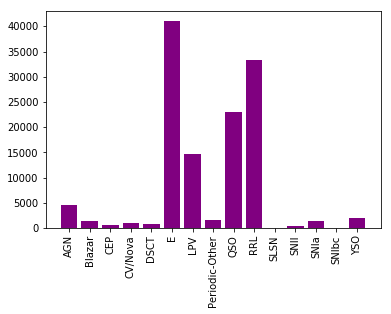

In [8]:
plt.bar(class_, number, color='purple')
plt.xticks(rotation=90)
plt.show()

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fmt = '.2f' if normalize else 'd'

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%{}".format(fmt)%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig('cm_BHRF.png', dpi=200)

### Generating train/test splits.

In [10]:
train, test = model_selection.train_test_split(merged_data, test_size=0.2, 
                     stratify=merged_data['classALeRCE'], random_state=42)

x_train, y_train, y_train_hier = train[feature_list], train.classALeRCE, train.hierClass
x_test, y_test, y_test_hier = test[feature_list], test.classALeRCE, test.hierClass

x_train_periodic = x_train.loc[y_train_hier=='Periodic', :]
y_train_periodic = y_train.loc[y_train_hier=='Periodic']

x_train_stochastic = x_train.loc[y_train_hier=='Stochastic', :]
y_train_stochastic = y_train.loc[y_train_hier=='Stochastic']

x_train_transient = x_train.loc[y_train_hier=='Transient', :]
y_train_transient = y_train.loc[y_train_hier=='Transient']

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

73667 25465 1416


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [11]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_hierarchical.fit(x_train, y_train_hier)
classes_order_proba_hierarchical = rf_model_hierarchical.classes_

#testing first layer performance

y_true, y_pred = y_test_hier, rf_model_hierarchical.predict(x_test)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(x_test)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

Accuracy: 0.9788359788359788
Balanced accuracy: 0.9746918062671724


Normalized confusion matrix


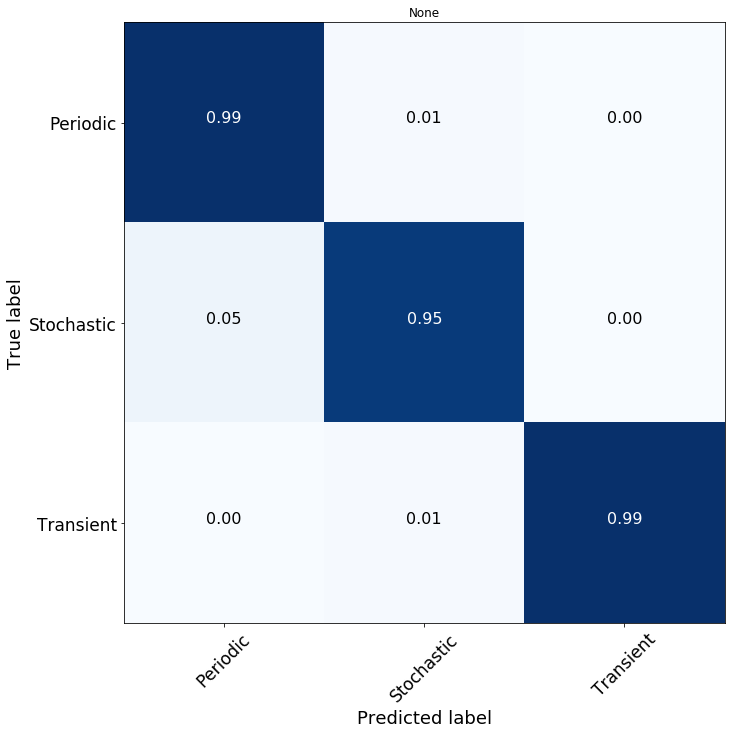

In [12]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix, rf_model_hierarchical.classes_)

In [13]:
#Saving the trained top model.

with open('../data/hierarchical_level_RF_model.pkl', 'wb') as f:
            pickle.dump(
                rf_model_hierarchical,
                f,
                pickle.HIGHEST_PROTOCOL)

### Training the root layers.

In [14]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            class_weight='balanced_subsample',
            bootstrap=True,
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(x_train_periodic, y_train_periodic)


# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test, rf_model_periodic.predict(x_test)
y_pred_proba_periodic = rf_model_periodic.predict_proba(x_test)

classes_order_proba_periodic = rf_model_periodic.classes_

  ### Stochastic layer

In [15]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features=0.2,#'auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(x_train_stochastic, y_train_stochastic)


# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test, rf_model_stochastic.predict(x_test)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(x_test)

classes_order_proba_stochastic = rf_model_stochastic.classes_

  ### Transient layer

In [16]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(x_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test, rf_model_transient.predict(x_test)
y_pred_proba_transient = rf_model_transient.predict_proba(x_test)

classes_order_proba_transient = rf_model_transient.classes_

 ## Putting al layers together  


In [17]:
# generating final probabilities

classes_order_proba_hierarchical = rf_model_hierarchical.classes_

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 8.041304545927751e-17
['AGN' 'Blazar' 'CV/Nova' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc' 'CEP'
 'DSCT' 'E' 'LPV' 'Periodic-Other' 'RRL']


Normalized confusion matrix
Accuracy: 0.80
Balanced accuracy: 0.73
macro precision:  0.56
macro recall:  0.73
macro F1:  0.58
                precision    recall  f1-score   support

           AGN       0.64      0.82      0.72       921
        Blazar       0.35      0.61      0.45       265
           CEP       0.16      0.66      0.25       126
       CV/Nova       0.60      0.66      0.63       188
          DSCT       0.13      0.86      0.23       154
             E       0.94      0.69      0.80      8214
           LPV       0.98      0.96      0.97      2923
Periodic-Other       0.12      0.69      0.21       313
           QSO       0.95      0.87      0.90      4604
           RRL       0.95      0.86      0.90      6685
          SLSN       0.18      0.75      0.29         4
          SNII       0.75      0.59      0.66        68
          SNIa       0.91      0.75      0.82       263
         SNIbc       0.12      0.47      0.19        19
           YSO       0.57      0.

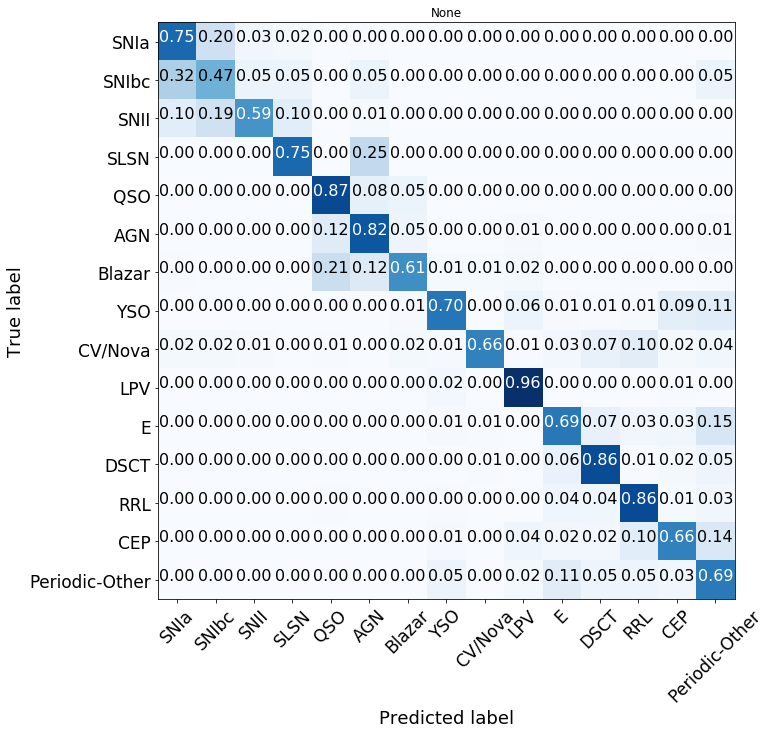

In [18]:
# generating confusion matrix for multilabels

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

cnf_matrix = metrics.confusion_matrix(y_test, class_final_name, labels=label_order)
plot_confusion_matrix(cnf_matrix,label_order)

print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test, class_final_name))

print("macro precision: ","%0.2f" %  metrics.precision_score(y_test, class_final_name, average='macro'))
print("macro recall: ","%0.2f" %  metrics.recall_score(y_test, class_final_name, average='macro'))
print("macro F1: ","%0.2f" %  metrics.f1_score(y_test, class_final_name, average='macro'))

print(metrics.classification_report(y_test, class_final_name, digits=2))

In [19]:
skf = model_selection.StratifiedKFold(n_splits=5)

for fold, (train_index, val_index) in enumerate(skf.split(train, train.classALeRCE)):
    fold_path = '../data/fold_{}_ixs.pkl'.format(fold)
    with open(fold_path, 'wb') as f:
            pickle.dump(
                train_index,
                f,
                pickle.HIGHEST_PROTOCOL)

In [20]:
test.to_pickle('../data/test_data_not_filtered.pkl')
train.to_pickle('../data/train_data_not_filtered.pkl')

# Predicting on unlabeled data

In [21]:
#removing training set from unlabeled data

features = features[~features['oid'].isin(train.oid)] 

In [22]:
x = features.set_index('oid')[feature_list].astype('float32')
x = x.replace([np.inf, -np.inf], np.nan)
x = x.fillna(-999)

probas = rf_model_hierarchical.predict_proba(x)

In [23]:
features['Periodic'] = probas[:,0]
features['Stochastic'] = probas[:,1]
features['Transient'] = probas[:,2]

In [25]:
features.to_pickle('../data/unlabeled_dataset_not_filtered.pkl')